## WeGo Data Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# This may take a long time to read in, so it would be advised to convert this to a csv early on.
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666


In [3]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS'],
      dtype='object')

In the data, the bus route can be identified by its ROUTE_ABBR value.  
**3:** West End  
**7:** Hillsboro  
**22:** Bordeaux  
**23:** Dickerson Pike  
**50:** Charlotte Pike  
**52:** Nolensville Pike  
**55:** Murfreesboro Pike  
**56:** Gallatin Pike

In [4]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25958
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

The trip can be identified by the DATE/CALENDAR_ID plus the TRIP_ID.  
**Warning:** The TRIP_ID refers to the route and time but will be used across multiple days.

The data contains multiple **time points** for each trip. There are more stops along the route than time points, but the time points are the points with specific scheduled times the bus operators must adhere to.

The first stop of a trip has a TRIP_EDGE of 1, the last has a TRIP_EDGE of 2, and the intermediate stops are TRIP_EDGE 0. 

Here is the first trip in the dataset. It was a Bordeaux route, scheduled to start at 4:42:00 and end at 5:10:00.

In [5]:
# scheduled time is time of departure
# trip edge 1 is the start, 0 is the intermeidate points, and trip edge 2 is the end.
wego[['DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']].loc[:3]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,8/1/2023,120230801,345104,22,MHSP,1,4:42:00
1,8/1/2023,120230801,345104,22,ELIZ,0,4:46:00
2,8/1/2023,120230801,345104,22,CV23,0,4:54:00
3,8/1/2023,120230801,345104,22,MCC5_10,2,5:10:00


Note that the same TRIP_ID appears on the following day.

In [6]:
(
    wego
    .loc[wego['DATE'].isin(['8/1/2023', '8/2/2023'])]
    .loc[wego['TRIP_ID'] == 345104]
    [['DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']]
)

,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,8/1/2023,22,345104,MHSP,1,4:42:00
1,8/1/2023,22,345104,ELIZ,0,4:46:00
2,8/1/2023,22,345104,CV23,0,4:54:00
3,8/1/2023,22,345104,MCC5_10,2,5:10:00
6461,8/2/2023,22,345104,MHSP,1,4:42:00
6462,8/2/2023,22,345104,ELIZ,0,4:46:00
6463,8/2/2023,22,345104,CV23,0,4:54:00
6464,8/2/2023,22,345104,MCC5_10,2,5:10:00


**Adherence** refers to the difference between scheduled time and the actual time that the bus departs from a stop.

A negative value for ADHERENCE indicates that the bus is late, and a positive indicates that the bus is early.

Generally, an adherence value less than -6 is considered late, and greater than 1 is considered early, but there are some exceptions. For example, a positive adherence for the end of a trip (TRIP_EDGE 2) is not considered early, since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. You can check whether a trip was considered on-time, early, or late using the ADJUSTED_EARLY_COUNT, ADJUSTED_LATE_COUNT, and ADJUSTED_ONTIME_COUNT columns.

Here is an example of a trip where all time points would be considered to be on time.

In [7]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[:3]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,8/1/2023,120230801,345104,22,MHSP,1,4:42:00,4:44:08,-2.133333,0,0,1
1,8/1/2023,120230801,345104,22,ELIZ,0,4:46:00,4:48:27,-2.450000,0,0,1
2,8/1/2023,120230801,345104,22,CV23,0,4:54:00,4:54:56,-0.933333,0,0,1
3,8/1/2023,120230801,345104,22,MCC5_10,2,5:10:00,5:03:43,6.283333,0,0,1


And one that has one late stop.

In [8]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[77:79]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
77,8/1/2023,120230801,345127,22,MHSP,1,17:05:00,17:08:21,-3.350000,0,0,1
78,8/1/2023,120230801,345127,22,CV23,0,17:14:00,17:20:10,-6.166666,0,1,0
79,8/1/2023,120230801,345127,22,MCC5_10,2,17:30:00,17:30:23,-0.383333,0,0,1


And one which was early.

In [9]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[11:13]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
11,8/1/2023,120230801,345107,22,MCC5_10,1,6:15:00,6:16:19,-1.316666,0,0,1
12,8/1/2023,120230801,345107,22,CV23,0,6:25:00,6:23:30,1.500000,1,0,0
13,8/1/2023,120230801,345107,22,MHSP,2,6:35:00,6:30:59,4.016666,0,0,1


**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 

The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

In [10]:
(
    wego
    .loc[wego['ROUTE_ABBR'] == 22]
    .loc[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']
    .loc[wego['TIME_POINT_ABBR'] == 'CV23']
    [['DATE', 'TRIP_ID', 'TIME_POINT_ABBR','ROUTE_DIRECTION_NAME',
      'SCHEDULED_TIME', 'SCHEDULED_HDWY',
      'ACTUAL_DEPARTURE_TIME', 'ACTUAL_HDWY', 'HDWY_DEV'
     ]]
    .sort_values(['DATE', 'SCHEDULED_TIME'])
    .iloc[:5]
)

,DATE,TRIP_ID,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,SCHEDULED_HDWY,ACTUAL_DEPARTURE_TIME,ACTUAL_HDWY,HDWY_DEV
227,8/1/2023,345297,CV23,TO DOWNTOWN,10:09:00,10.0,10:09:34,8.866666,-1.133334
432,8/1/2023,345415,CV23,TO DOWNTOWN,10:22:00,13.0,10:22:52,13.300000,0.300000
164,8/1/2023,345223,CV23,TO DOWNTOWN,10:34:00,12.0,NaN,NaN,NaN
346,8/1/2023,345387,CV23,TO DOWNTOWN,10:47:00,13.0,10:49:39,26.783333,13.783333
43,8/1/2023,345116,CV23,TO DOWNTOWN,10:59:00,12.0,11:00:47,11.133333,-0.866667


One column that you've been asked to explore is the DWELL_IN_MINS column, which shows the difference between actual arrival and actual departure time at a time point. 

In [11]:
wego.loc[4:4, ['DATE', 'TRIP_ID', 'TRIP_EDGE',
               'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'DWELL_IN_MINS']]

,DATE,TRIP_ID,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,DWELL_IN_MINS
4,8/1/2023,345105,1,5:03:43,5:16:35,12.866666


# 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [12]:
#SCHEDULED_TIME and ACTUAL_ARRIVAL_TIME, and ACTUAL_DEPARTURE_TIME
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
3,120230801,1,99457893,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,35,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000
350324,120230930,2,100406611,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,551,0.000000
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000
350326,120230930,2,100406613,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,47.500000,17.500000,0,1,0,0,0.0,0,563,0.000000


In [13]:
wego.columns = wego.columns.str.lower()
wego = wego.loc[wego['trip_edge'] != 2]
wego

,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,...,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,block_stop_order,dwell_in_mins
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
5,120230801,1,99457895,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,51,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350320,120230930,2,100406607,9/30/2023,7,702,2312,353447,0,FROM DOWNTOWN,...,NaN,NaN,0,0,0,0,0.0,0,515,NaN
350322,120230930,2,100406609,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,34.916666,4.916666,0,1,0,0,0.0,0,530,1.966666
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.000000
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.000000


In [14]:
wego_clean = wego.fillna('null')
wego_clean = wego_clean.loc[(wego_clean['adherence'] != 'null')]
wego_clean

,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,...,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,block_stop_order,dwell_in_mins
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,null,null,0,0,1,0,0.0,0,2,6.5
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,null,null,0,0,1,0,0.0,0,9,0.0
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,null,null,0,0,1,0,0.0,0,19,0.0
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,null,null,0,0,1,0,0.0,0,36,12.866666
5,120230801,1,99457895,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,null,null,0,0,1,0,0.0,0,51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350319,120230930,2,100406606,9/30/2023,7,702,2312,353447,0,FROM DOWNTOWN,...,36.716666,6.716666,0,0,1,0,0.0,0,504,7.033333
350322,120230930,2,100406609,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,34.916666,4.916666,0,1,0,0,0.0,0,530,1.966666
350323,120230930,2,100406610,9/30/2023,7,702,2312,353448,0,TO DOWNTOWN,...,35.266666,5.266666,0,1,0,0,0.0,0,539,0.0
350325,120230930,2,100406612,9/30/2023,7,702,2312,353449,0,FROM DOWNTOWN,...,31.866666,1.866666,0,0,1,0,0.0,0,552,0.0


In [15]:
for ind, row in wego_clean.iterrows():
    if row.adherence > 1:
        wego_clean.loc[ind, 'on_time_performance'] = 'Early'
    elif row.adherence < -6:
        wego_clean.loc[ind, 'on_time_performance'] = 'Late'
    else:
        wego_clean.loc[ind, 'on_time_performance'] = 'On Time'

In [16]:
OTP_count = wego_clean.on_time_performance.value_counts().to_frame().reset_index()
OTP_count

,on_time_performance,count
0,On Time,217544
1,Late,46633
2,Early,9406


In [17]:
#OTP_count['percent'] = OTP_count['count'] + OTP_count[1] + OTP_count[2]
#OTP_count

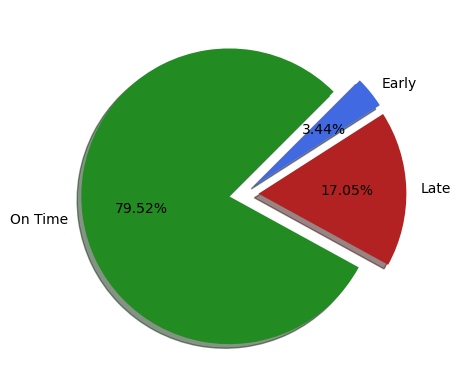

In [18]:
labels = 'On Time', 'Late', 'Early'
sizes = [217544, 46633, 9406]

explode = (0.1, 0.1, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
       shadow=True, startangle=45,
       colors=['forestgreen', 'firebrick', 'royalblue']);
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

In [19]:
#expanding the above information by day

In [20]:
wego.head()

,calendar_id,service_abbr,adherence_id,date,route_abbr,block_abbr,operator,trip_id,overload_id,route_direction_name,...,actual_hdwy,hdwy_dev,adjusted_early_count,adjusted_late_count,adjusted_ontime_count,stop_cancelled,prev_sched_stop_cancelled,is_relief,block_stop_order,dwell_in_mins
0,120230801,1,99457890,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,2,6.500000
1,120230801,1,99457891,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,9,0.000000
2,120230801,1,99457892,8/1/2023,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,19,0.000000
4,120230801,1,99457894,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,36,12.866666
5,120230801,1,99457895,8/1/2023,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,51,0.000000


In [21]:
wego_clean['date'] = pd.to_datetime(wego_clean['date'])

In [22]:
wego_clean['day'] = wego_clean['date'].dt.day_name()

In [23]:
day_OTP = wego_clean[['day', 'on_time_performance']]
day_OTP

,day,on_time_performance
0,Tuesday,On Time
1,Tuesday,On Time
2,Tuesday,On Time
4,Tuesday,On Time
5,Tuesday,On Time
...,...,...
350319,Saturday,On Time
350322,Saturday,Late
350323,Saturday,Late
350325,Saturday,On Time


In [24]:
#dictionary to new column to sort values
day_to_num = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
day_OTP['day_num'] = day_OTP['day'].map(day_to_num)
day_OTP = day_OTP.sort_values(by='day_num')
day_OTP

C:\Users\derek\AppData\Local\Temp\ipykernel_16084\3020905424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_OTP['day_num'] = day_OTP['day'].map(day_to_num)


,day,on_time_performance,day_num
195230,Monday,On Time,1
38685,Monday,On Time,1
38686,Monday,On Time,1
38687,Monday,On Time,1
38688,Monday,On Time,1
...,...,...,...
73311,Sunday,On Time,7
73310,Sunday,On Time,7
73309,Sunday,On Time,7
73318,Sunday,On Time,7


In [25]:
day_OTP.day.value_counts()

day
Wednesday    45893
Tuesday      45792
Thursday     45363
Friday       45087
Monday       38739
Saturday     29640
Sunday       23069
Name: count, dtype: int64

In [26]:
daily_breakdown = day_OTP.groupby(['day','on_time_performance']).value_counts().reset_index()
daily_breakdown = daily_breakdown.sort_values('day_num')
daily_breakdown

,day,on_time_performance,day_num,count
3,Monday,Early,1,1572
4,Monday,Late,1,4804
5,Monday,On Time,1,32363
17,Tuesday,On Time,2,36698
16,Tuesday,Late,2,7524
15,Tuesday,Early,2,1570
20,Wednesday,On Time,3,36307
18,Wednesday,Early,3,1521
19,Wednesday,Late,3,8065
14,Thursday,On Time,4,35577


C:\Users\derek\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


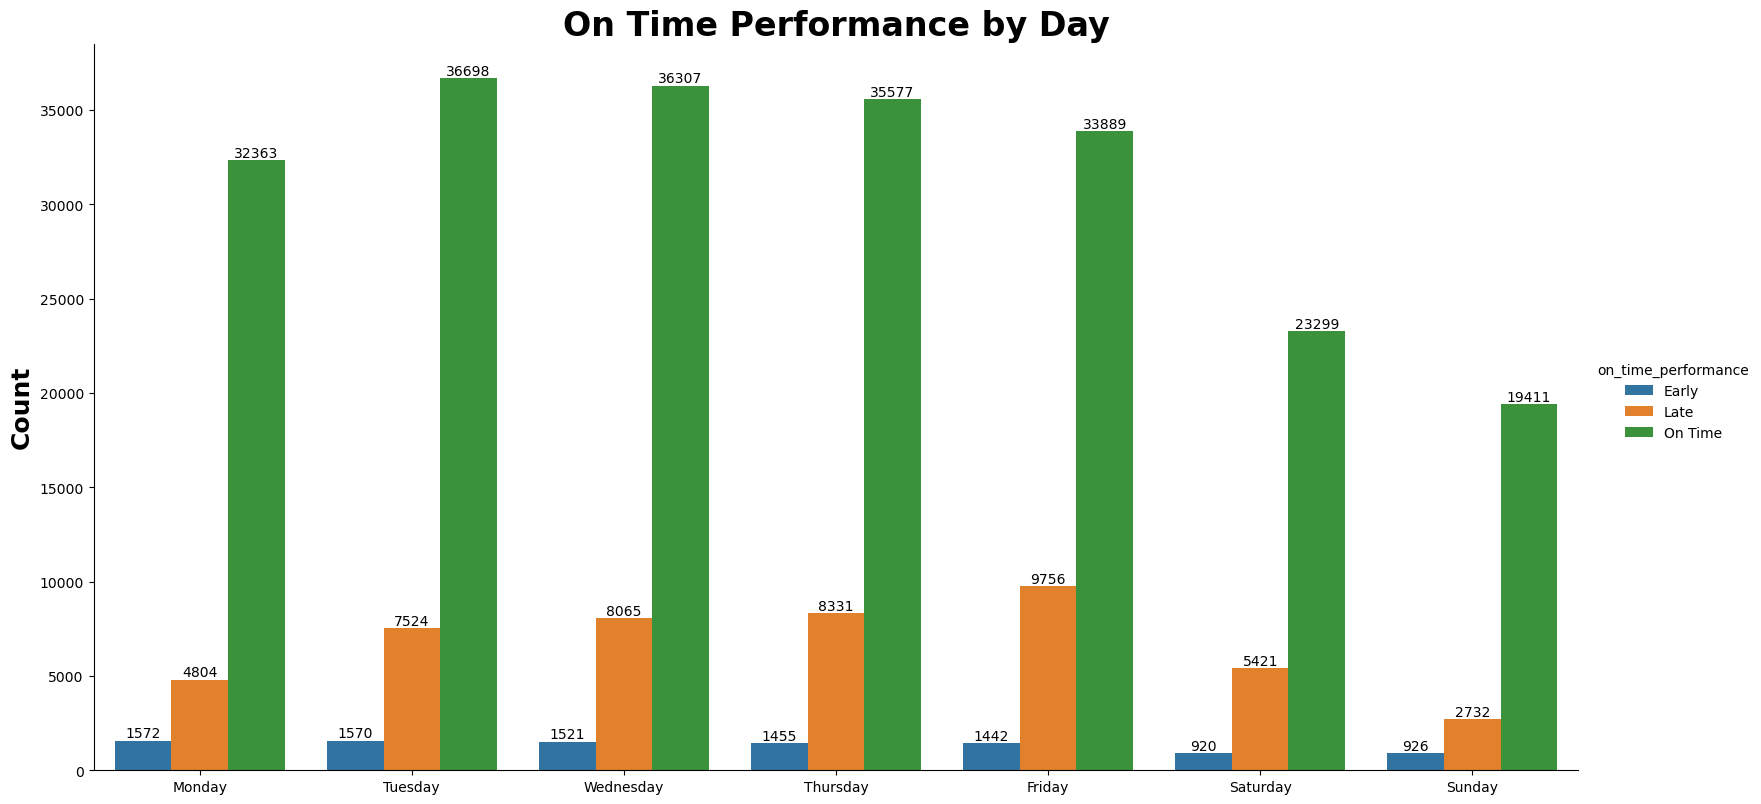

In [27]:
graph = sns.catplot(
        data=daily_breakdown, x="day", y="count", hue="on_time_performance",
        kind="bar", height=8, aspect=2)
for ax in graph.axes.flat:
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.bar_label(ax.containers[2])
plt.title('On Time Performance by Day', fontsize = 24, fontweight = 'bold')
plt.ylabel('Count', fontsize = 18, fontweight = 'bold')
plt.xlabel('');
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

# By Operator Performance

In [28]:
OP_OTP = wego_clean[['operator', 'on_time_performance']]
OP_OTP

,operator,on_time_performance
0,1040,On Time
1,1040,On Time
2,1040,On Time
4,1040,On Time
5,1040,On Time
...,...,...
350319,2312,On Time
350322,2312,Late
350323,2312,Late
350325,2312,On Time


In [29]:
OP_OTP = OP_OTP.groupby(['operator','on_time_performance']).value_counts().reset_index()
OP_OTP

,operator,on_time_performance,count
0,56,On Time,2
1,235,Early,1
2,235,Late,4
3,235,On Time,5
4,244,Late,4
...,...,...,...
956,3165,Late,16
957,3165,On Time,8
958,3166,Late,3
959,3166,On Time,26


In [30]:
top_OPS = OP_OTP[['operator','count']]
top_OPS = top_OPS.groupby('operator')['count'].sum().to_frame().reset_index()
top_OPS = top_OPS.sort_values('count', ascending = False)
top_OPS.reset_index(drop= True)

,operator,count
0,1266,2390
1,1133,2190
2,1147,2168
3,2352,2123
4,2424,2060
...,...,...
334,2435,7
335,2377,7
336,2256,4
337,56,2


In [31]:
top_OPS = top_OPS.head(10).reset_index
top_OPS

<bound method DataFrame.reset_index of      operator  count
50       1266   2390
36       1133   2190
37       1147   2168
188      2352   2123
200      2424   2060
4         304   2026
197      2399   2024
7         332   2023
132      1927   2002
267      2760   1970>

In [32]:
#finish by operator^^^^^^

# 1B. what do the overall distributions of adherence and headway deviation look like?

# Adherence

In [33]:
wego_clean[['scheduled_time', 'actual_departure_time', 'adherence']]

,scheduled_time,actual_departure_time,adherence
0,4:42:00,4:44:08,-2.133333
1,4:46:00,4:48:27,-2.45
2,4:54:00,4:54:56,-0.933333
4,5:15:00,5:16:35,-1.583333
5,5:25:00,5:24:03,0.95
...,...,...,...
350319,21:45:00,21:50:54,-5.9
350322,22:16:00,22:24:37,-8.616666
350323,22:23:00,22:31:26,-8.433333
350325,22:45:00,22:49:19,-4.316666


In [34]:
wego_clean['adherence'].describe()

count     273583.00
unique      3358.00
top            0.95
freq        1274.00
Name: adherence, dtype: float64

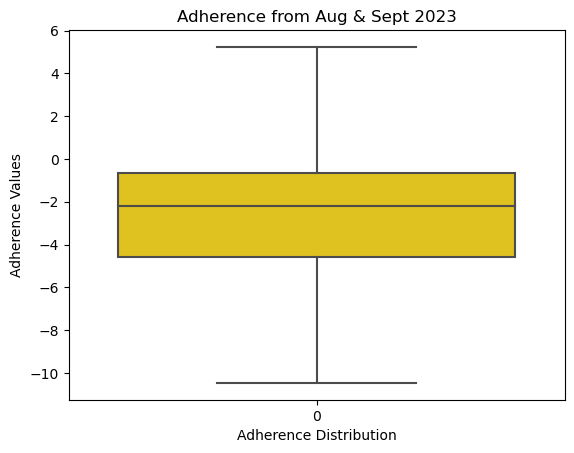

In [35]:
sns.boxplot(wego_clean.adherence, showfliers = False, color = 'gold')
plt.xlabel('Adherence Distribution')
plt.ylabel('Adherence Values')
plt.title('Adherence from Aug & Sept 2023')
plt.show()
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

# Headway 
-hdwy_dev is "bunching"::::::::::: 
+hdwy_dev is "gapping":::::::::::
headway deviation % as hdwy_dev/scheduled_hdwy

headway, bus leaves bus stop, start a stop watch, stop timer when next bus arrives

In [36]:
wego_clean['hdwy_dev'].describe()

count     273583
unique      4218
top         null
freq        7691
Name: hdwy_dev, dtype: object

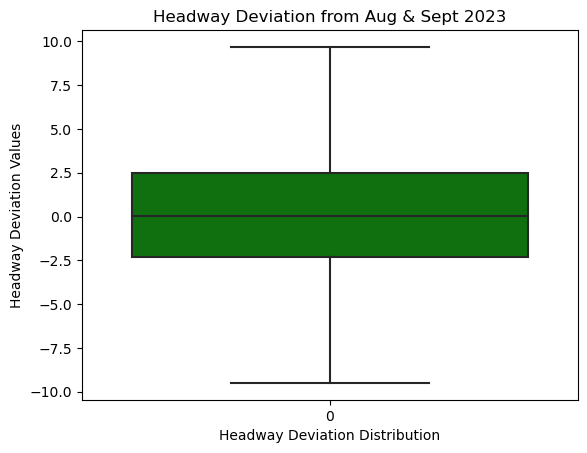

In [37]:
sns.boxplot(wego.hdwy_dev, showfliers = False, color = 'green')
plt.xlabel('Headway Deviation Distribution')
plt.ylabel('Headway Deviation Values')
plt.title('Headway Deviation from Aug & Sept 2023')
plt.show()
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32

In [38]:
hdwy_metrics = wego_clean[['scheduled_hdwy','actual_hdwy','hdwy_dev']]
hdwy_metrics

,scheduled_hdwy,actual_hdwy,hdwy_dev
0,null,null,null
1,null,null,null
2,null,null,null
4,null,null,null
5,null,null,null
...,...,...,...
350319,30.0,36.716666,6.716666
350322,30.0,34.916666,4.916666
350323,30.0,35.266666,5.266666
350325,30.0,31.866666,1.866666


In [39]:
hdwy_metrics = hdwy_metrics.fillna('null')

In [40]:
hdwy_metrics = hdwy_metrics.loc[(hdwy_metrics['scheduled_hdwy'] != 'null') & 
                  (hdwy_metrics['actual_hdwy'] != 'null') & 
                  (hdwy_metrics['hdwy_dev'] != 'null')]

In [41]:
hdwy_metrics = hdwy_metrics.reset_index(drop = True)
hdwy_metrics

,scheduled_hdwy,actual_hdwy,hdwy_dev
0,35.0,37.666666,2.666666
1,35.0,36.966666,1.966666
2,15.0,14.516666,-0.483334
3,15.0,12.833333,-2.166667
4,15.0,11.116666,-3.883334
...,...,...,...
265887,30.0,36.716666,6.716666
265888,30.0,34.916666,4.916666
265889,30.0,35.266666,5.266666
265890,30.0,31.866666,1.866666


In [42]:
350328 - 265892 #84436 Nulls

84436

In [43]:
for ind, row in hdwy_metrics.iterrows():
    if row.actual_hdwy > (row.scheduled_hdwy * 1.5):
        hdwy_metrics.loc[ind, 'overall_headway_deviation'] = 'Gapping'
    elif row.actual_hdwy < (row.scheduled_hdwy * 0.5):
        hdwy_metrics.loc[ind, 'overall_headway_deviation'] = 'Bunching'    
    else:
        hdwy_metrics.loc[ind, 'overall_headway_deviation'] = 'On Time'

In [44]:
#w/o Nulls in hdwy_metrics
HM_clean = hdwy_metrics.overall_headway_deviation.value_counts().to_frame().reset_index()
HM_clean

,overall_headway_deviation,count
0,On Time,225920
1,Gapping,21973
2,Bunching,17999


C:\Users\derek\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


IndexError: list index out of range

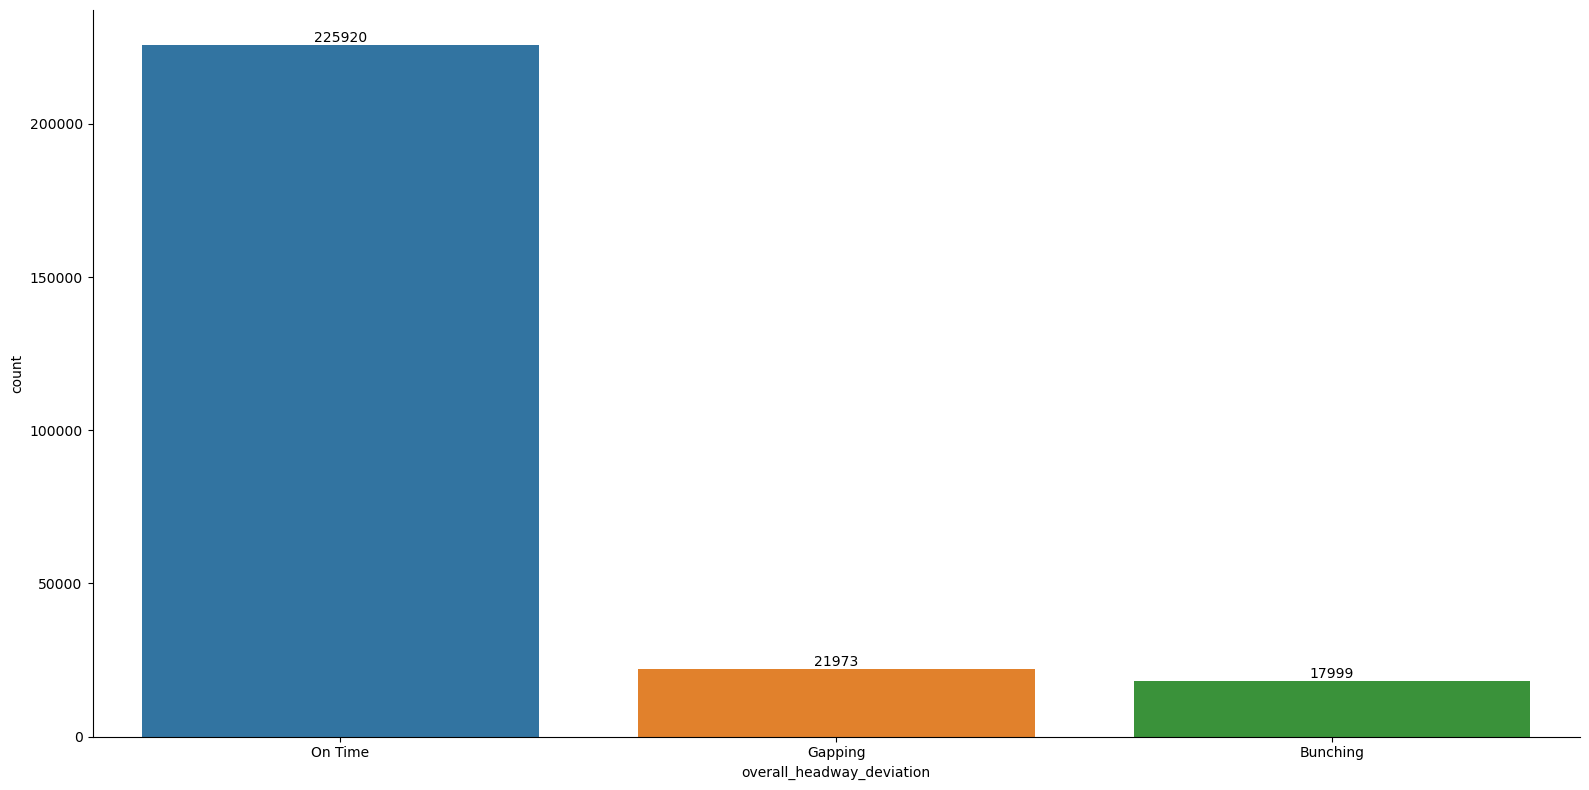

In [45]:
graph = sns.catplot(
        data=HM_clean, x="overall_headway_deviation", y="count",
        kind="bar", height=8, aspect=2)
for ax in graph.axes.flat:
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.bar_label(ax.containers[2])
plt.title('Clean Headway Deviation', fontsize = 24, fontweight = 'bold')
plt.ylabel('Count', fontsize = 18, fontweight = 'bold')
plt.xlabel('Overall Headway Deviation');
#- WeGo purple: #6F4DA0 or RGB: 111, 77, 160
#- WeGo silver: #939598 or RGB: 147, 149, 152
#- WeGo black: #231f20 or RGB: 35, 31, 32